# Evaluation of ELSA and Top-K SAE Query-Boosted Recommender

This notebook evaluates:
- Offline performance (Recall@20, NDCG@20) on MovieLens
- Algorithm behavior with different queries and preferences through data collected via EasyStudy

Key findings:
- The data I collected was not enough to validate the hypothesis that query boost will make recommendations more relevant. The results were highly dependent on the query and preference elicitation. For some queries,  query-boosted recommendations were much better, while for others, they decreased the overall recommendation quality.

Model configurations:
- ELSA: latent_dim = 512
- SAE: width_ratio = 4 (hidden_dim = 2048), k = 32 (~1.6% sparsity)

In [103]:
# Standard imports for analysis
import os
import json
import glob
import re
import pickle
import sqlite3
from collections import Counter
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')

## Load preprocessed train and test data

In [104]:
with open("C:\\Users\\elisk\\Desktop\\2024-25\\LS\\Recommenders\\semestral_project\\EasyStudy\\server\\data\\processed_train.pkl", "rb") as f:
    X_train = pickle.load(f)
with open("C:\\Users\\elisk\\Desktop\\2024-25\\LS\\Recommenders\\semestral_project\\EasyStudy\\server\\data\\processed_test.pkl", "rb") as f:
    X_test = pickle.load(f)

X_train = X_train.toarray()
X_test = X_test.toarray()

## Load trained ELSA and SAE models

In [105]:
from train_elsa import ELSA, latent_dim
from train_sae import TopKSAE, k, hidden_dim

num_items = X_train.shape[1]

elsa = ELSA(num_items, latent_dim)
elsa.load_state_dict(torch.load("C:\\Users\\elisk\\Desktop\\2024-25\\LS\\Recommenders\\semestral_project\\EasyStudy\\server\\models\\elsa_model_best.pt"))
elsa.eval()

sae = TopKSAE(latent_dim, hidden_dim, k)
sae.load_state_dict(torch.load("C:\\Users\\elisk\\Desktop\\2024-25\\LS\\Recommenders\\semestral_project\\EasyStudy\\server\\models\\sae_model_r4_k32.pt"))
sae.eval()

TopKSAE(
  (enc): Linear(in_features=512, out_features=2048, bias=False)
  (dec): Linear(in_features=2048, out_features=512, bias=True)
)

## Define metric functions

In [106]:
def recall_at_k(y_true, y_pred, k):
    hits = y_true[y_pred[:k]].sum()
    total_relevant = y_true.sum()
    return hits / total_relevant if total_relevant > 0 else np.nan

def ndcg_at_k(y_true, y_pred, k):
    hits = y_true[y_pred[:k]]
    if hits.sum() == 0:
        return 0.0
    gains = hits / np.log2(np.arange(2, k + 2))
    dcg = gains.sum()
    ideal_hits = np.sort(y_true)[::-1][:k]
    ideal_gains = ideal_hits / np.log2(np.arange(2, k + 2))
    idcg = ideal_gains.sum()
    return dcg / idcg if idcg > 0 else 0.0

## Compute offline metrics

In [107]:
with open("C:\\Users\\elisk\\Desktop\\2024-25\\LS\\Recommenders\\semestral_project\\EasyStudy\\server\\data\\item2index.pkl", "rb") as f:
    item2index = pickle.load(f)

recall_20_plain = []
ndcg_20_plain = []
recall_20_sae = []
ndcg_20_sae = []

for i in range(X_test.shape[0]):
    user_full = X_test[i] if hasattr(X_test[i], 'toarray') else X_test[i]
    if hasattr(user_full, 'toarray'):
        user_full = user_full.toarray().squeeze()
    
    # Skip users with insufficient interactions
    nonzero_items = np.where(user_full > 0)[0]
    if len(nonzero_items) < 5:
        continue

    # 20% holdout per user
    np.random.seed(42 + i)
    n_holdout = max(1, int(len(nonzero_items) * 0.2))
    holdout_items = np.random.choice(nonzero_items, size=n_holdout, replace=False)

    user_input = user_full.copy()
    user_target = np.zeros_like(user_full)
    
    user_input[holdout_items] = 0
    user_target[holdout_items] = user_full[holdout_items]

    user_train = torch.tensor(user_input, dtype=torch.float32).unsqueeze(0)

    with torch.no_grad():
        # ELSA predictions
        z = torch.matmul(user_train, elsa.A)
        z_norm = torch.nn.functional.normalize(z, dim=-1)
        recon_plain = torch.matmul(z_norm, elsa.A.T)

        # SAE predictions  
        recon_z, h_sparse, h_pre = sae(z_norm)
        recon_sae = torch.matmul(recon_z, elsa.A.T)

    # Scores computation
    scores_plain = recon_plain - user_train
    scores_sae = recon_sae - user_train

    scores_plain_np = scores_plain.squeeze().numpy()
    scores_sae_np = scores_sae.squeeze().detach().numpy()
    
    # Mask out training items
    scores_plain_np[user_input > 0] = -np.inf
    scores_sae_np[user_input > 0] = -np.inf

    top_plain = np.argsort(-scores_plain_np)
    top_sae = np.argsort(-scores_sae_np)

    recall_20_plain.append(recall_at_k(user_target, top_plain, 20))
    ndcg_20_plain.append(ndcg_at_k(user_target, top_plain, 20))
    recall_20_sae.append(recall_at_k(user_target, top_sae, 20))
    ndcg_20_sae.append(ndcg_at_k(user_target, top_sae, 20))

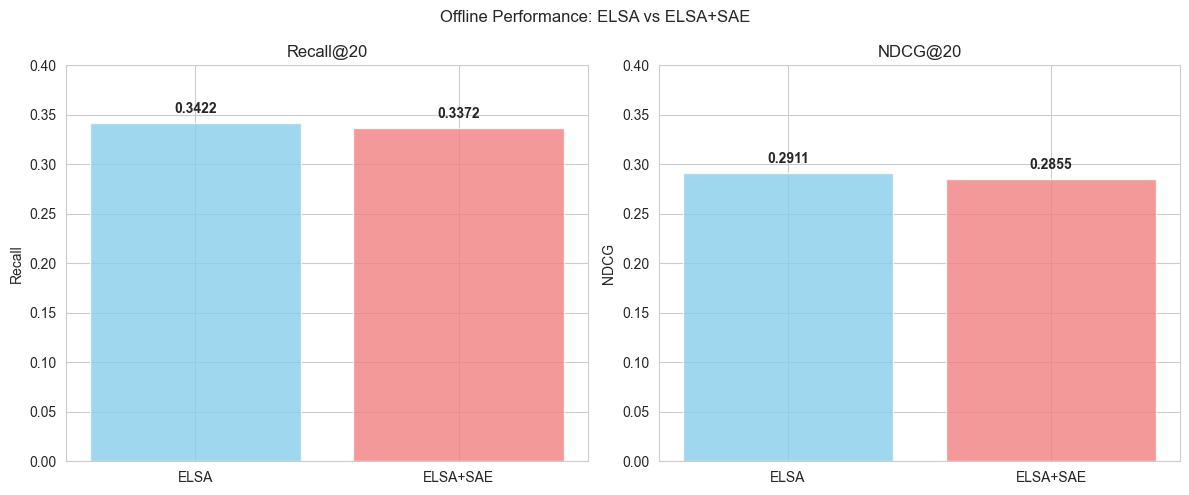

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

models = ['ELSA', 'ELSA+SAE']
recall = [np.nanmean(recall_20_plain), np.nanmean(recall_20_sae)]
ndcg = [np.nanmean(ndcg_20_plain), np.nanmean(ndcg_20_sae)]

ax1.bar(models, recall, color=['skyblue', 'lightcoral'], alpha=0.8)
ax1.set_title('Recall@20')
ax1.set_ylabel('Recall')
ax1.set_ylim(0, 0.4)
for i, v in enumerate(recall):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

ax2.bar(models, ndcg, color=['skyblue', 'lightcoral'], alpha=0.8)
ax2.set_title('NDCG@20')
ax2.set_ylabel('NDCG')
ax2.set_ylim(0, 0.4)
for i, v in enumerate(ndcg):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

plt.suptitle('Offline Performance: ELSA vs ELSA+SAE')
plt.tight_layout()
plt.show()

SAE layer did not significantly decrease performance of the algorithm. Now, let's evaluate how query-boosting worked.

## Query boosting
SAE neurons were mapped to tags and genres in the Movielens dataset. I have used 2 approaches, both implemented in `map_neurons_to_tags.py`:
- TF-IDF (which was used in the original paper)
- Centroid (mean of neuron activations)

Both of these methods achieved comparable numerical results (entropy, sparsity, separation), so I have compared their practical behavior through EasyStudy.

I have only used tags with at least 50 occurrences and also excluded low quality tags and some negation tags to avoid confusion (such as boosting "not funny" for the query "funny").

Then I computed tag embeddings in `embeddings.py`.

Predictions are made using `EasyStudy\server\plugins\fastcompare\algo\query_boost_elsa.py` or `semestral_project\EasyStudy\server\plugins\fastcompare\algo\query_boost_elsa_tf_idf.py`. The boost is applied to up to 10 most similar tags with weighted combination and it's amplified by a factor of 50 to make the results clearly visible.

I have used `alpha = 0.3` in experiments and I did about 3 full sessions (me and one additional user) and a few experiments with less iterations. Some additional information about algorithm behavior (query interpretation, most boosted movies) has been logged to the `logs` folder for easier interpretation.

## Load user study results

In [109]:
import sqlite3
import json
import pandas as pd
import numpy as np

# Connect to EasyStudy database
db_path = "C:\\Users\\elisk\\Desktop\\2024-25\\LS\\Recommenders\\semestral_project\\EasyStudy\\server\\instance\\db_2.sqlite"

with sqlite3.connect(db_path) as conn:
    # Load participation data filtered for study_id = 27
    df_participation = pd.read_sql_query("""
        SELECT * FROM participation 
        WHERE user_study_id = 27 or user_study_id = 28 or user_study_id = 26
    """, conn)

    print(f"Loaded {len(df_participation)} participations for study 27")

    # Load interaction data for these participants
    participant_ids = df_participation['id'].tolist()
    if participant_ids:
        placeholders = ','.join('?' * len(participant_ids))
        interaction_query = f"""
            SELECT * FROM interaction 
            WHERE participation IN ({placeholders})
        """
        df_interaction = pd.read_sql_query(interaction_query, conn, params=participant_ids)
    else:
        df_interaction = pd.DataFrame()

    print(f"Loaded {len(df_interaction)} interactions for study 27")
    display(df_interaction.head())


Loaded 13 participations for study 27
Loaded 1668 interactions for study 27


,id,participation,interaction_type,time,data
0,561,7,loaded-page,2025-09-18 10:21:46.232753,"{""page"": ""preference_elicitation"", ""context"": ..."
1,562,7,changed-viewport,2025-09-18 10:21:51.198623,"{""viewport"": {""left"": 0, ""top"": 0, ""width"": 14..."
2,563,7,elicitation-ended,2025-09-18 10:22:03.965669,"{""elicitation_movies"": [], ""elicitation_select..."
3,564,7,iteration-started,2025-09-18 10:22:03.986734,"{""iteration"": 1, ""movies"": {""ELSA"": {""movies"":..."
4,565,7,loaded-page,2025-09-18 10:22:04.711709,"{""page"": ""compare_algorithms"", ""context"": {""ur..."


In [110]:
# 1. Extract ratings from iteration-ended
def extract_ratings(row):
    if row['interaction_type'] == 'iteration-ended':
        try:
            data = json.loads(row['data'])
            return {
                'ratings': data.get('ratings', []),
                'iteration': data.get('iteration', None),
                'selected': data.get('selected', []),
                'algorithm_comparison': data.get('algorithm_comparison', []),
                'algorithm_comparison_selected': data.get('selected', [])  # Movies selected in comparison
            }
        except:
            return {}
    return {}

# 2. Extract algorithm assignment from iteration-started  
def extract_algorithm_assignment(row):
    if row['interaction_type'] == 'iteration-started':
        try:
            data = json.loads(row['data'])
            return {
                'algorithm_assignment': data.get('algorithm_assignment', {}),
                'iteration': data.get('iteration', None),
                'movies': data.get('movies', [])
            }
        except:
            return {}
    return {}

# 3. Extract query and elicitation movies from elicitation-ended
def extract_query_and_elicitation(row):
    if row['interaction_type'] == 'elicitation-ended':
        try:
            data = json.loads(row['data'])
            return {
                'query': data.get('query', None),
                'elicitation_selected_movies': data.get('elicitation_selected_movies', []),
                'selected_movies': data.get('selected', [])  # Alternative field name
            }
        except:
            return {}
    return {}

# Apply extractions
d = df_interaction[~df_interaction['interaction_type'].isin(['loaded-page', 'changed-viewport', 'on-input', 'selected-item'])].copy()
d['rating_data'] = d.apply(extract_ratings, axis=1)
d['algorithm_data'] = d.apply(extract_algorithm_assignment, axis=1) 
d['elicitation_data'] = d.apply(extract_query_and_elicitation, axis=1)

# Load movies data for ID to title mapping
try:
    movies_df = pd.read_csv("C:\\Users\\elisk\\Desktop\\2024-25\\LS\\Recommenders\\semestral_project\\EasyStudy\\server\\data\\movies.csv")
    print(f"Loaded {len(movies_df)} movies for ID mapping")
    
    # Create ID to title mapping
    id_to_title = {}
    if 'movieId' in movies_df.columns and 'title' in movies_df.columns:
        id_to_title = dict(zip(movies_df['movieId'], movies_df['title']))
    elif 'id' in movies_df.columns and 'title' in movies_df.columns:
        id_to_title = dict(zip(movies_df['id'], movies_df['title']))
    else:
        print("Warning: Could not find movieId/id and title columns in movies data")
        print("Available columns:", movies_df.columns.tolist())
        
except Exception as e:
    print(f"Could not load movies data: {e}")
    id_to_title = {}

def convert_ids_to_titles(movie_list):
    """Convert movie IDs to titles in a list, keeping non-ID items unchanged"""
    if not isinstance(movie_list, list):
        return movie_list
    
    result = []
    for item in movie_list:
        try:
            if isinstance(item, (int, float)) and item in id_to_title:
                result.append(id_to_title[item])
            elif isinstance(item, list):
                subresult = []
                for sub_item in item:
                    if isinstance(sub_item, (int, float)) and sub_item in id_to_title:
                        subresult.append(id_to_title[sub_item])
                    else:
                        subresult.append(sub_item)  # Keep as-is if not a valid movie ID
                result.append(subresult)
            else:
                result.append(item)
        except:
            result.append(item)  # Keep as-is if any error
    
    return result

# Group by participation to combine data
results = []
for participation_id in d['participation'].unique():
    participant_data = d[d['participation'] == participation_id]
    
    # Get query (should be same for all interactions in participation)
    queries = [row['elicitation_data'].get('query') for _, row in participant_data.iterrows() 
              if row['elicitation_data'].get('query')]
    user_query = queries[0] if queries else None
    
    # Get elicitation selected movies
    elicitation_movies = []
    for _, row in participant_data.iterrows():
        if row['elicitation_data'].get('elicitation_selected_movies'):
            elicitation_movies.extend(row['elicitation_data']['elicitation_selected_movies'])
    
    # Remove duplicates while preserving order
    elicitation_movies = list(dict.fromkeys(elicitation_movies))
    
    # Convert movie IDs to titles
    elicitation_movies = convert_ids_to_titles(elicitation_movies)
    
    # Get algorithm assignments
    algorithm_assignments = {}
    recommended_movies = {}
    for _, row in participant_data.iterrows():
        if row['algorithm_data'].get('algorithm_assignment'):
            algorithm_assignments.update(row['algorithm_data']['algorithm_assignment'])
        if row['algorithm_data'].get('movies'):
            recommended_movies.update(row['algorithm_data']['movies'])
    
    # Get ratings for each iteration
    for _, row in participant_data.iterrows():
        if row['rating_data'].get('ratings'):
            iteration = row['rating_data']['iteration']
            ratings_list = row['rating_data']['ratings']
            comparison_selected = row['rating_data'].get('algorithm_comparison_selected', [])
            
            # Convert comparison selected movie IDs to titles - handle nested structure
            if isinstance(comparison_selected, list):
                comparison_selected = convert_ids_to_titles(comparison_selected)
            elif isinstance(comparison_selected, dict):
                # If it's a dict with algorithm names as keys
                comparison_selected = {alg: convert_ids_to_titles(movies) if isinstance(movies, list) else movies 
                                     for alg, movies in comparison_selected.items()}
            
            for rating_set in ratings_list:
                for algorithm, rating in rating_set.items():
                    results.append({
                        'user_id': participation_id,
                        'iteration': iteration, 
                        'algorithm': algorithm,
                        'rating': rating,
                        'query': user_query,
                        'algorithm_assignment': algorithm_assignments,
                        'elicitation_movies': elicitation_movies,
                        'recommended_movies': recommended_movies,
                        'comparison_selected_movies': comparison_selected,
                        'timestamp': row['time']
                    })
    
# Create final dataset
df_complete = pd.DataFrame(results)
display(df_complete.head())

Loaded 58098 movies for ID mapping


,user_id,iteration,algorithm,rating,query,algorithm_assignment,elicitation_movies,recommended_movies,comparison_selected_movies,timestamp
0,10,1,ELSA,4,"documentaries about pyramids, scifi, comedies","{'0': {'algorithm': 'ELSA', 'name': 'ELSA', 'o...","[Full Metal Jacket (1987), Silences of the Pal...",{'ELSA': {'movies': [{'movie': 'Borat: Cultura...,"[[Nine Months (1995), Angel on My Shoulder (19...",2025-09-22 18:26:29.330482
1,10,1,ELSA+SAE Query,3,"documentaries about pyramids, scifi, comedies","{'0': {'algorithm': 'ELSA', 'name': 'ELSA', 'o...","[Full Metal Jacket (1987), Silences of the Pal...",{'ELSA': {'movies': [{'movie': 'Borat: Cultura...,"[[Nine Months (1995), Angel on My Shoulder (19...",2025-09-22 18:26:29.330482
2,10,1,ELSA+SAE Query TF-IDF,2,"documentaries about pyramids, scifi, comedies","{'0': {'algorithm': 'ELSA', 'name': 'ELSA', 'o...","[Full Metal Jacket (1987), Silences of the Pal...",{'ELSA': {'movies': [{'movie': 'Borat: Cultura...,"[[Nine Months (1995), Angel on My Shoulder (19...",2025-09-22 18:26:29.330482
3,10,2,ELSA,4,"documentaries about pyramids, scifi, comedies","{'0': {'algorithm': 'ELSA', 'name': 'ELSA', 'o...","[Full Metal Jacket (1987), Silences of the Pal...",{'ELSA': {'movies': [{'movie': 'Borat: Cultura...,"[[Nine Months (1995), Angel on My Shoulder (19...",2025-09-22 18:32:37.143814
4,10,2,ELSA+SAE Query,3,"documentaries about pyramids, scifi, comedies","{'0': {'algorithm': 'ELSA', 'name': 'ELSA', 'o...","[Full Metal Jacket (1987), Silences of the Pal...",{'ELSA': {'movies': [{'movie': 'Borat: Cultura...,"[[Nine Months (1995), Angel on My Shoulder (19...",2025-09-22 18:32:37.143814


=== 1. ALGORITHM PERFORMANCE BY ITERATION ===


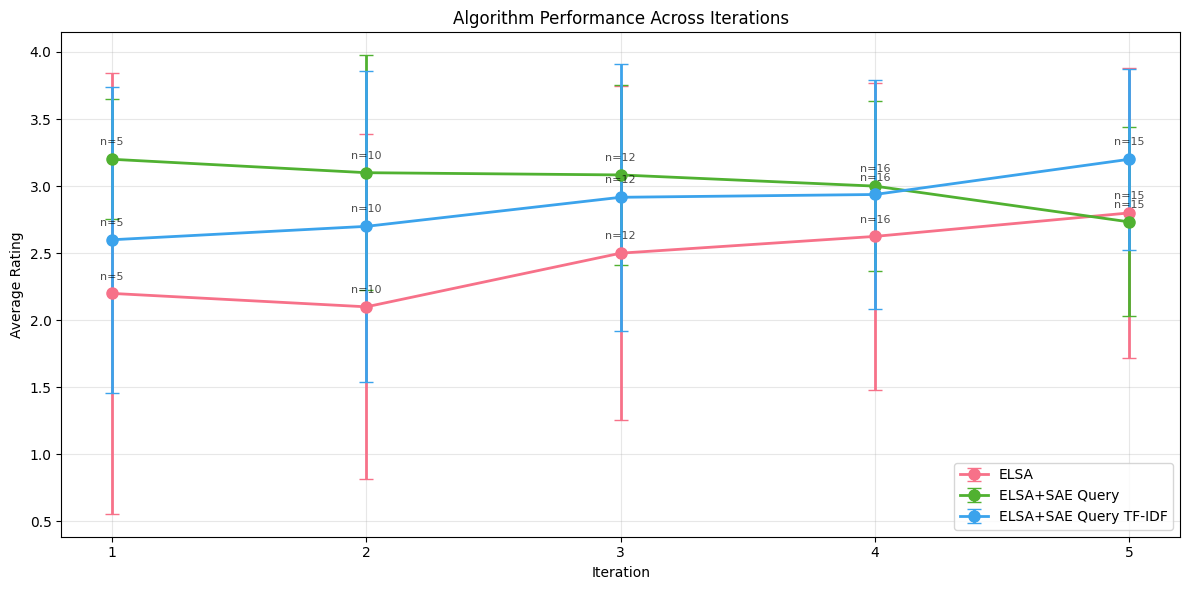


=== 2. QUERY EFFECTIVENESS ANALYSIS ===


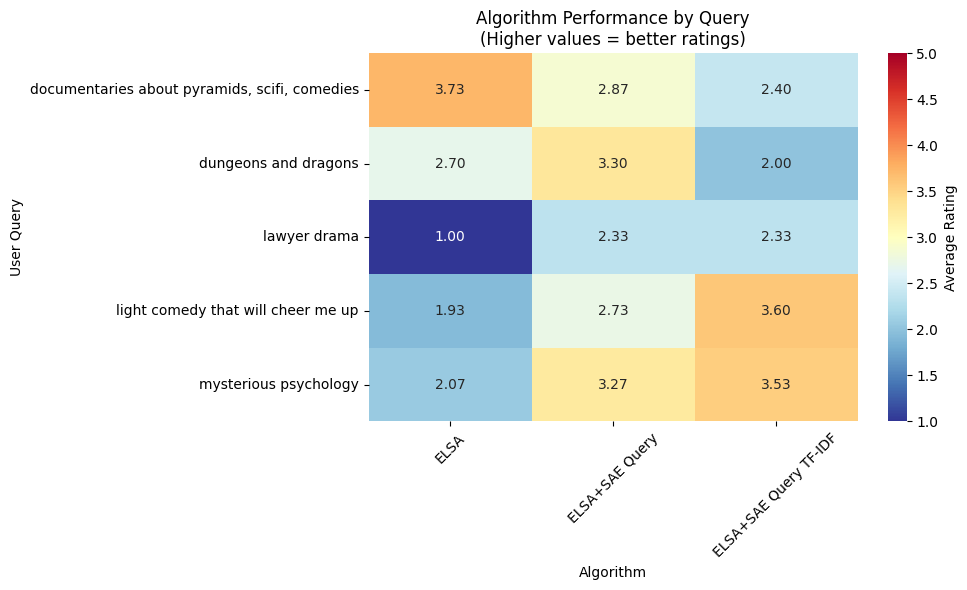


Query frequency:
  'documentaries about pyramids, scifi, comedies': 45 ratings
  'mysterious psychology': 45 ratings
  'light comedy that will cheer me up': 45 ratings
  'dungeons and dragons': 30 ratings
  'lawyer drama': 9 ratings


In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('default')
sns.set_palette("husl")

def plot_algorithm_performance_by_iteration():
    """Show how ratings change across iterations for each algorithm"""
    
    if len(df_complete) == 0:
        print("No data available for analysis")
        return
    
    # Calculate mean rating by algorithm and iteration
    iteration_performance = df_complete.groupby(['algorithm', 'iteration'])['rating'].agg(['mean', 'count', 'std']).reset_index()
    
    plt.figure(figsize=(12, 6))
    
    # Plot mean ratings with error bars
    algorithms = iteration_performance['algorithm'].unique()
    colors = sns.color_palette("husl", len(algorithms))
    
    for i, alg in enumerate(algorithms):
        alg_data = iteration_performance[iteration_performance['algorithm'] == alg]
        plt.errorbar(alg_data['iteration'], alg_data['mean'], 
                    yerr=alg_data['std'], 
                    label=alg, marker='o', linewidth=2, markersize=8,
                    color=colors[i], capsize=5)
    
    plt.xlabel('Iteration')
    plt.ylabel('Average Rating')
    plt.title('Algorithm Performance Across Iterations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(sorted(df_complete['iteration'].unique()))
    
    # Add sample size annotations
    for i, row in iteration_performance.iterrows():
        if row['count'] > 0:
            plt.annotate(f"n={int(row['count'])}", 
                        (row['iteration'], row['mean']), 
                        textcoords="offset points", xytext=(0,10), ha='center',
                        fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return iteration_performance

def plot_query_effectiveness():
    """Compare algorithm performance for different queries"""
    
    if len(df_complete) == 0:
        print("No data available for analysis")
        return
    
    # Group by query and algorithm
    query_performance = df_complete.groupby(['query', 'algorithm'])['rating'].agg(['mean', 'count']).reset_index()
    
    # Create pivot table for heatmap
    pivot_data = query_performance.pivot(index='query', columns='algorithm', values='mean')
    
    plt.figure(figsize=(10, max(6, len(pivot_data) * 0.5)))
    
    # Create heatmap
    sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlBu_r', 
                center=3, vmin=1, vmax=5, cbar_kws={'label': 'Average Rating'})
    
    plt.title('Algorithm Performance by Query\n(Higher values = better ratings)')
    plt.xlabel('Algorithm')
    plt.ylabel('User Query')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Also show query frequency
    query_counts = df_complete['query'].value_counts()
    print("\nQuery frequency:")
    for query, count in query_counts.items():
        print(f"  '{query}': {count} ratings")
    
    return pivot_data

# Execute all analyses
print("=== 1. ALGORITHM PERFORMANCE BY ITERATION ===")
iteration_perf = plot_algorithm_performance_by_iteration()

print("\n=== 2. QUERY EFFECTIVENESS ANALYSIS ===")
query_eff = plot_query_effectiveness()


=== 3. ALGORITHM PERFORMANCE DISTRIBUTION ===


C:\Users\elisk\AppData\Local\Temp\ipykernel_18120\127565386.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_for_boxplot, labels=algorithms, patch_artist=True)


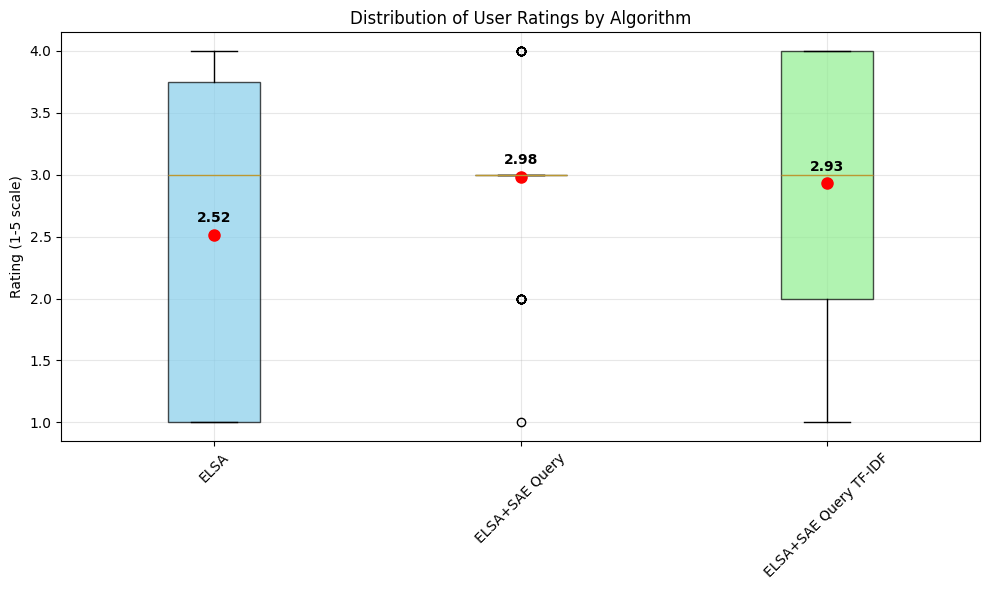


=== 4. PREFERENCE ELICITATION IMPACT ANALYSIS ===


C:\Users\elisk\AppData\Local\Temp\ipykernel_18120\127565386.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elicitation_performance = df_complete.groupby(['algorithm', 'elicitation_bin'])['rating'].agg(['mean', 'count', 'std']).reset_index()


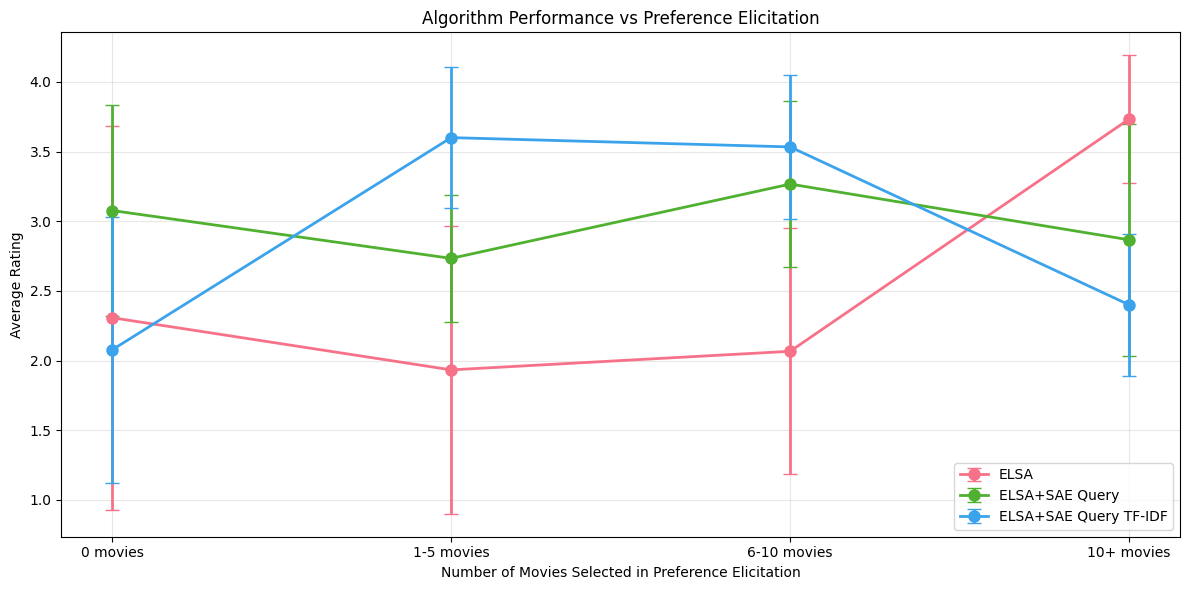


=== SUMMARY STATISTICS ===
                       N_Ratings  Mean_Rating  Std_Rating  Median_Rating  \
algorithm                                                                  
ELSA                          58        2.517       1.203            3.0   
ELSA+SAE Query                58        2.983       0.688            3.0   
ELSA+SAE Query TF-IDF         58        2.931       0.915            3.0   

                       Avg_Elicitation_Count  
algorithm                                     
ELSA                                   7.241  
ELSA+SAE Query                         7.241  
ELSA+SAE Query TF-IDF                  7.241  

ANOVA F-test: F=4.108, p=0.0181
✅ Differences between algorithms are statistically significant!


In [112]:
def plot_algorithm_boxplot():
    """Create boxplot showing distribution of ratings for each algorithm"""
    
    if len(df_complete) == 0:
        print("No data available for analysis")
        return
    
    plt.figure(figsize=(10, 6))
    
    # Create boxplot
    algorithms = df_complete['algorithm'].unique()
    data_for_boxplot = [df_complete[df_complete['algorithm'] == alg]['rating'].values 
                        for alg in algorithms]
    
    box_plot = plt.boxplot(data_for_boxplot, labels=algorithms, patch_artist=True)
    
    # Color the boxes
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    for patch, color in zip(box_plot['boxes'], colors[:len(algorithms)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.ylabel('Rating (1-5 scale)')
    plt.title('Distribution of User Ratings by Algorithm')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add mean markers
    for i, alg in enumerate(algorithms):
        mean_rating = df_complete[df_complete['algorithm'] == alg]['rating'].mean()
        plt.plot(i+1, mean_rating, 'ro', markersize=8, label=f'Mean: {mean_rating:.2f}' if i == 0 else "")
        plt.text(i+1, mean_rating + 0.1, f'{mean_rating:.2f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Preference Elicitation Analysis
def analyze_preference_elicitation_impact():
    """Analyze how the number of selected movies during elicitation affects ratings"""
    
    if len(df_complete) == 0:
        print("No data available for analysis")
        return
    
    # Count elicitation movies per user
    df_complete['elicitation_count'] = df_complete['elicitation_movies'].apply(
        lambda x: len(x) if isinstance(x, list) else 0
    )
    
    # Create elicitation count bins
    df_complete['elicitation_bin'] = pd.cut(df_complete['elicitation_count'], 
                                           bins=[-1, 0, 5, 10, 100],
                                           labels=['0 movies', '1-5 movies', '6-10 movies', '10+ movies'])
    
    plt.figure(figsize=(12, 6))
    
    # Chart: Rating vs Elicitation Count by Algorithm
    elicitation_performance = df_complete.groupby(['algorithm', 'elicitation_bin'])['rating'].agg(['mean', 'count', 'std']).reset_index()
    
    algorithms = df_complete['algorithm'].unique()
    colors = sns.color_palette("husl", len(algorithms))
    
    for i, alg in enumerate(algorithms):
        alg_data = elicitation_performance[elicitation_performance['algorithm'] == alg]
        plt.errorbar(range(len(alg_data)), alg_data['mean'], 
                    yerr=alg_data['std'], 
                    label=alg, marker='o', linewidth=2, markersize=8,
                    color=colors[i], capsize=5)
    
    plt.xlabel('Number of Movies Selected in Preference Elicitation')
    plt.ylabel('Average Rating')
    plt.title('Algorithm Performance vs Preference Elicitation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(range(len(elicitation_performance['elicitation_bin'].unique())), 
               elicitation_performance['elicitation_bin'].unique())
    
    plt.tight_layout()
    plt.show()
    
    return elicitation_performance

print("\n=== 3. ALGORITHM PERFORMANCE DISTRIBUTION ===")
plot_algorithm_boxplot()

print("\n=== 4. PREFERENCE ELICITATION IMPACT ANALYSIS ===")
elicitation_analysis = analyze_preference_elicitation_impact()

print("\n=== SUMMARY STATISTICS ===")
summary_stats = df_complete.groupby('algorithm').agg({
    'rating': ['count', 'mean', 'std', 'median'],
    'elicitation_count': 'mean'
}).round(3)
summary_stats.columns = ['N_Ratings', 'Mean_Rating', 'Std_Rating', 'Median_Rating', 'Avg_Elicitation_Count']
print(summary_stats)

# Statistical significance test
from scipy.stats import f_oneway
algorithms = df_complete['algorithm'].unique()
if len(algorithms) >= 2:
    algorithm_ratings = [df_complete[df_complete['algorithm'] == alg]['rating'].values for alg in algorithms]
    f_stat, p_value = f_oneway(*algorithm_ratings)
    print(f"\nANOVA F-test: F={f_stat:.3f}, p={p_value:.4f}")
    if p_value < 0.05:
        print("✅ Differences between algorithms are statistically significant!")
    else:
        print("ℹ️ No statistically significant differences detected.")

We can see that query-boosted recommendations generally perform better during the first iteration. However, they can also propagate lower-quality recommendations. Once ELSA gets additional feedback and its recommendations get query-relevant too, it can even outperform query-boosting.

Most of the time, centroid approach delivered better results in the first iterations, but it could sometimes diverge during consequent iterations.

The quality of results was largely dependent on the query and preference elicitation. When the user delivered a query that was hard to interpret, but selected a lot of movies during preference elicitation, ELSA delivered significantly better results. However, when only a few movies or no movies were selected during preference elicitation, boosted results were much better; especially in the first iteration.

Now, let's examine the algorithm behavior further using log files.

# Log analysis

The logs were evaluated manually, and with the help of Claude Sonnet 4 (where I was not familiar with the movies or for additional insights).

### "lawyer drama" Query Analysis
The algorithm correctly interpreted legal themes with high similarity scores:
- `'lawyer movie tag'`: 0.586 (excellent)
- `'courtroom drama movie tag'`: 0.564 (excellent) 
- `'lawyers movie tag'`: 0.562 (excellent)
- `'law movie tag'`: 0.477 (good)

**Correctly Boosted Movies:**
- **Erin Brockovich (2000)**: +0.312 boost - Perfect legal drama about lawyer vs corporation
- **Few Good Men, A (1992)**: +0.269 boost - Classic military courtroom drama  
- **Philadelphia (1993)**: +0.180/+0.329 boost - AIDS discrimination lawsuit drama
- **Legally Blonde (2001)**: +0.244 boost - Law school comedy-drama

**Incorrect Generic Drama Tag Pollution:**
- `'family drama movie tag'`: 0.408 - Too broad, caused false positives
- `'scandal movie tag'`: 0.397 - Too tangential to legal themes

**Incorrectly Boosted Popular Movies:**
- **Titanic (1997)**: +0.273 boost - Disaster/romance, NOT legal drama
- **Good Will Hunting (1997)**: +0.298 boost - Psychology drama, NOT legal  
- **Miss Congeniality (2000)**: +0.242 boost - FBI comedy, not courtroom focus
- **Contact (1997)**: +0.210 boost - Sci-fi, no legal themes whatsoever

### "mysterious psychology" Query Analysis
**Strong Psychology Tag Detection:**
- `'group psychology movie tag'`: 0.421 (excellent)
- `'psychology movie tag'`: 0.387 (good)
- `'psychological movie tag'`: 0.378 (good)
- `'psychologist movie tag'`: 0.357 (good)

**Perfect Matches:**
- **Gone Girl (2014)**: +0.469 boost - Psychological thriller
- **Memento (2000)**: +0.402 boost - Memory/psychology themes
- **Shutter Island (2010)**: +0.393 boost - Psychological mystery
- **Donnie Darko (2001)**: +0.441 boost - Mind-bending psychological drama

### "dungeons and dragons" Query
**Fantasy Theme Success:**
- `'fantasy movie genre'`: 0.428 (excellent)
- `'dragons movie tag'`: 0.406 (excellent)  
- `'dragon movie tag'`: 0.367 (good)
- `'adventure movie genre'`: 0.358 (good)

**Correctly Boosted:**
- **Harry Potter series**: Massive boosts (+0.531, +0.504, +0.502) - Perfect fantasy match
- **How to Train Your Dragon (2010)**: +0.188/+0.254 - Literal dragon content
- **Tangled (2010)**: +0.379/+0.254 - Fantasy adventure with magic

**Algorithm Confusion:**
- `'dinosaurs movie tag'`: 0.330 - ❌ Confused dragons with dinosaurs
- **Despicable Me (2010)**: +0.245/+0.303 boost - Animated but not fantasy

### "light commedy that will cheer me up" Query
The algorithm correctly interpreted comedy themes with high similarity scores:
- `'stand up comedy movie tag'`: 0.584 (excellent)
- `'good romantic comedies movie tag'`: 0.549 (excellent)
- `'comedy movie genre'`: 0.545 (excellent)
- `'romantic comedy movie tag'`: 0.509 (excellent)

**Correctly Boosted Movies:**
- **40-Year-Old Virgin, The (2005)**: +0.544 boost – Classic comedy
- **Wedding Crashers (2005)**: +0.523 boost – Romantic comedy
- **Superbad (2007)**: +0.514 boost – Teen comedy
- **Anchorman: The Legend of Ron Burgundy (2004)**: +0.432 boost – Satirical comedy
- ...

**Tag Pollution:**
- `'dark comedy movie tag'`: 0.473 – Can boost movies with dark themes
- `'crude humor movie tag'`: 0.471 – May not match "light" intent

**Incorrectly Boosted Movies:**
- **Pulp Fiction (1994)**: +0.222 boost – Crime, not comedy
- **Reservoir Dogs (1992)**: +0.209 boost – Crime, not comedy
- **American History X (1998)**: +0.200 boost – Drama, not comedy

## Possible Algorithm Improvements

1. **Limit the number of boosted tags**: 10 tags might be too much for some queries, set a minimal similarity threshold
2. **Consider negative boosting**: we could negatively boost neurons with opposite meaning
3. **Advanced query processing**: use a more sophisticated approach than just semantic similarity
4. **Allow user control over query influence strength**


### Method Comparison: Centroid vs TF-IDF

The behavior was highly dependent on the query. Some queries were better interpreted by one method and some were better interpreted by another. Generally, TF-IDF provided more perfect matches, but inconsistently, while centroid results were mostly "not great, not terrible". However, TF-IDF results got better with additional feedback, while centroid results did not improve.

# Conclusion

### ✅ What Worked
- SAE layer maintained offline performance (minimal degradation)
- Query interpretation was semantically reasonable for specific domains
- Both methods correctly identified core theme tags
- Technical implementation functioned as designed

### ❌ What Failed
- Generic tags caused too many false positives
- Popular movies got boosted regardless of relevance
- No negative filtering to prevent obvious mistakes
- Results got bad if the query was hard to interpret, vague or there were not enough quality movies with this topic (pyramids query)

Query-boosting proved efficient especially when users provided minimal preference data, but as users provided more feedback, its performance became similar to ELSA. It also performed better when query was well-specified and easy to interpret. When the user provides enough feedback but a vague query, query-boosting might steer the results in an unexpected direction and lower the recommendation quality.